<a href="https://colab.research.google.com/github/Leanse1/NLP-with-Transformers/blob/main/Sentiment_Analysis_in_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roadmap
1. Installation
2. Imports
3. Loading Model
4. Data Preparation
5. Modelling
6. Training
7. Testing

# Installation

In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00


# Imports

In [ ]:
import tensorflow as tf   ### models
import numpy as np   ### math computations
import matplotlib.pyplot as plt   ### plotting bar chart
import sklearn   ### machine learning library
import cv2   ## image processing
from sklearn.metrics import confusion_matrix, roc_curve   ### metrics
import seaborn as sns ### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset  # To load IMdB dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

In [ ]:
BATCH_SIZE=8

# Loading Model

In [ ]:
dataset_id='imdb'
dataset = load_dataset(dataset_id)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

#DATA PREPARATION

## Data Preparation for Bert Model

"Uncased" version, all words are converted to lowercase before training. This allows the model to be case-insensitive, meaning it treats "apple" and "Apple" as the same word.

In [ ]:
model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.is_fast

True

In [ ]:
test_input_1='The Weather of Today is Gréat! zwp'
test_input_2='How are you doing?'
inputs=[test_input_1,test_input_2]

tokenizer.tokenize(inputs)

['the',
 'weather',
 'of',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [ ]:
output=tokenizer(inputs,padding=True,truncation=True,max_length=128)
print(output)

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


1. '101' represents class token;
2. '102' represents seperator token to seperate two sentence
3. Token_type_id - To differentiate between type of sentences
4. Attention Mask - Position which we need to give attention and position which are not needed attention
5. Truncation - give max length for sentences

In [ ]:
tokenizer.decode(output['input_ids'][0])

'[CLS] the weather of today is great! zwp [SEP]'

In [ ]:
tokenizer.decode(output['input_ids'][1])

'[CLS] how are you doing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

####Tokenizing the dataset

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tokenized_dataset['train'][0]

To collate (combine) and pad sequences of tokenized text data into batches, making them suitable for training transformer-based models.

In [ ]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Converting to TF dataset

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

Seperating features of dataset as input and output

In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [ ]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[ 101, 1045, 1005, ...,    0,    0,    0],
       [ 101, 1999, 2857, ..., 2065, 2017,  102],
       [ 101, 1045, 2572, ...,    0,    0,    0],
       ...,
       [ 101, 1011, 2453, ..., 2136, 2125,  102],
       [ 101, 7929, 1011, ..., 2053, 2613,  102],
       [ 101, 7570, 1011, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 0, 1, 0, 0, 0, 0])>

In [ ]:
tf_val_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Data Preparation for Roberta Model

In [ ]:
model_id="roberta-base"
tokenizer=RobertaTokenizerFast.from_pretrained(model_id)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function,)# batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train'][0]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [ ]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[    0,   133,  1569, ...,     1,     1,     1],
       [    0,   100,    21, ...,     1,     1,     1],
       [    0,   713, 22154, ...,     1,     1,     1],
       ...,
       [    0, 15852,    57, ...,     1,     1,     1],
       [    0,   133,   527, ...,     1,     1,     1],
       [    0,   100,   794, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 1, 1, 0, 0, 1, 1])>)


## Data Preparation for XtremeDistill Model

Using the teacher model to learn student model.

For building a smaller model with high accuracy

In [ ]:
model_id="microsoft/xtremedistil-l6-h256-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

In [ ]:
tokenizer.is_fast

True

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"],max_length=512,padding=True,truncation=True,)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [ ]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_val_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[  101, 11374,  2515, ...,  1010,  2002,   102],
       [  101,  2203, 27242, ...,     0,     0,     0],
       [  101,  1045,  2031, ...,     0,     0,     0],
       ...,
       [  101,  1045,  1005, ...,  1996,  5494,   102],
       [  101,  1045,  2001, ...,     0,     0,     0],
       [  101,  2023,  2143, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(16,), dtype=int64

In [ ]:
tf_val_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Modeling

## Based on TFBertForSequenceClassification

To classify sequences of text like sentiment analysis, spam classfication

In [ ]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

## Based on XtremeDistillForSequenceClassification

In [ ]:
model=TFBertForSequenceClassification.from_pretrained(model_id,num_labels=2)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  12750080  
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  514       
                                                                 
Total params: 12,750,594
Trainable params: 12,750,594
Non-trainable params: 0
_________________________________________________________________


## Based on TFBertModel - Including Customisation

In [ ]:
model=TFBertModel.from_pretrained("bert-base-uncased")
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
input_ids=Input(shape = (512,),dtype=tf.int64,name='input_ids')
token_type_ids=Input(shape = (512,),dtype=tf.int64,name='token_type_ids')
attention_mask=Input(shape = (512,),dtype=tf.int64,name='attention_mask')

x = model([input_ids,token_type_ids,attention_mask])
print(x)
# Since we are interested in very first token x[0] out of 512 of transformer box
x=Dense(128,activation='relu')(x[0][:,0,:])
# Since our output is a single class output
output=Dense(1,activation='sigmoid',name='label')(x)

custom_bert = tf.keras.Model(inputs=[input_ids,token_type_ids,attention_mask], outputs=output)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [ ]:
custom_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

## Based on TFRobertaForSequenceClassification - Advanced form of Bert

In [ ]:
model=TFRobertaForSequenceClassification.from_pretrained(model_id,num_labels=2)
model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [ ]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [ ]:
history=model.fit(
    tf_train_dataset.take(1000),
    validation_data=tf_val_dataset,
    epochs=3,)

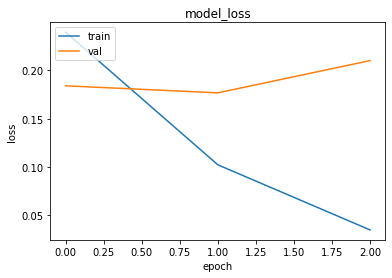

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

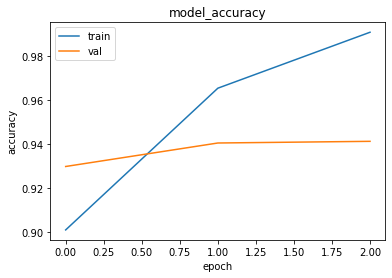

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing


In [ ]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[-2.2396984  1.9407922]
 [ 3.3462846 -3.3634923]], shape=(2, 2), dtype=float32)


# Conversion to Onnx Format

## Installation

In [3]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu #-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 2.5 MB/s eta 0:00:00


In [4]:
import onnxruntime as rt
import tf2onnx
rt.get_device()

'CPU'

## From Keras Model

In [ ]:
output_path = "/content/drive/MyDrive/nlp/sentiment_analysis/xtremedistill.onnx"

In [ ]:
spec = [tf.TensorSpec((None,512),tf.int64, name="input_ids"),
        tf.TensorSpec((None,512),tf.int64, name="token_type_ids"),
        tf.TensorSpec((None,512),tf.int64, name="attention_mask")]

model_proto, _ = tf2onnx.convert.from_keras(
    model, input_signature=spec,
    opset=17, output_path=output_path,)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

['logits']


# Inference

## Benchmarking Onnx

In [ ]:
text=["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes!"]

# text = ["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
#                     "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over ",
#                     "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so overall i will give this movie a pass "]


inputs = tokenizer(text,padding='max_length',max_length=512,truncation=True,return_tensors="np")

N_PREDICTIONS = 1
print(inputs)

{'input_ids': array([[ 101, 2023, 3185, ...,    0,    0,    0],
       [ 101, 2200, 2204, ...,    0,    0,    0],
       [ 101, 2200, 2204, ...,    0,    0,    0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}


In [ ]:
providers=['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

t1 = time.time()
for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(["logits"], {'input_ids':inputs['input_ids'],
                                'token_type_ids':inputs['token_type_ids'],
                                'attention_mask':inputs['attention_mask']})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 1.01802659034729


In [ ]:
print(onnx_pred)

[array([[-1.9962329 ,  2.3427389 ],
       [ 0.14644536, -0.15334648],
       [-0.66496277,  0.7874055 ]], dtype=float32)]


## Benchmarking TF

In [ ]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  logits = model(**inputs).logits
print(logits)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

tf.Tensor([[-1.9962313  2.3427382]], shape=(1, 2), dtype=float32)
Time for a single Prediction 0.6114558053016662


In [ ]:
tf, cpu = 600ms
tf, gpu = 130ms
tf_size = 50MB

onnx, cpu = 400ms
onnx, gpu = 8ms
onnx_size = 50MB
onnx_acc  = 91.9%

onnx_quantized, cpu = 190ms
onnx_quantized, gpu = 140ms
onnx_quantized_size = 13MB
onnx_quantized_acc  = 89.7%

# Quantization with Onnx

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/drive/MyDrive/nlp/sentiment_analysis/xtremedistill.onnx'
model_quant = '/content/drive/MyDrive/nlp/sentiment_analysis/xtremedistill_quantized.onnx'

In [ ]:
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification_1/bert/encoder/layer_._3/attention/self/MatMul_1]
Ignore M

## Accuracy Drop due to Quantization

In [ ]:
unbatched_val_dataset=tf_val_dataset.unbatch()

In [ ]:
N_SAMPLES=1024

In [ ]:
def accuracy(model):
  total=0
  for text,label in unbatched_val_dataset.take(N_SAMPLES):

    onnx_pred = model.run(["logits"], {'input_ids':[text['input_ids'].numpy()],
                                'token_type_ids':[text['token_type_ids'].numpy()],
                                'attention_mask':[text['attention_mask'].numpy()]})
    if np.argmax(onnx_pred, axis = -1)[0][0] == label.numpy():
      total+=1
  return (total/N_SAMPLES)*100

In [ ]:
providers=['CPUExecutionProvider']
m = rt.InferenceSession(model_fp32, providers=providers)
m_q = rt.InferenceSession(model_quant, providers=providers)
print(accuracy(m_q))
print(accuracy(m))

89.6484375
91.89453125
